In [97]:
import os
import itertools
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from Utils.properties import HAC

In [98]:
property_list = ['logP', 'tPSA', 'QED']

tol = [0.4, 8, 0.03]
trg_prop_settings = {
    'logP': [ 1.0,   2.0,  3.0],
    'tPSA': [30.0,  60.0, 90.0],
    'QED' : [ 0.6, 0.725, 0.85],
}

In [99]:
def get_trg_prop_list():
    # get property combinations

    prop_set = (trg_prop_settings[p] for p in property_list)
    prop_comb = list(itertools.product(*prop_set))
    trg_prop_list = [list(c) for c in prop_comb]
    return trg_prop_list


def get_n_train():
    n_train = []
    trg_prop_list = get_trg_prop_list()
    train = pd.read_csv('/fileserver-gamma/chaoting/ML/dataset/moses/raw/train.csv', index_col=[0])

    for i, prop in enumerate(trg_prop_list):
        filtered = train[(prop[0] - tol[0] <= train.logP) & (train.logP <= prop[0] + tol[0])]
        filtered = filtered[(prop[1] - tol[1] <= filtered.tPSA) & (filtered.tPSA <= prop[1] + tol[1])]
        filtered = filtered[(prop[2] - tol[2] <= filtered.QED) & (filtered.QED <= prop[2] + tol[2])]
        n_train.append(len(filtered))
    return n_train


def add_hac(df):
    mols = list(map(Chem.MolFromSmiles, df['scaffold']))
    df['HAC'] = list(map(HAC, mols))
    return df

def plot_smiles_group(smiles, save_path, substructure=None, n_per_mol=None,
                      img_size=None, descriptions=None, n_jobs=1):
    kwargs = {}
    kwargs['useSVG'] = False
    kwargs['returnPNG'] = False
    # kwargs['vspace'] = 2

    molecules = list(map(Chem.MolFromSmiles, smiles))
    kwargs['mols'] = molecules
    
    if substructure:
        substr_mols = list(map(Chem.MolFromSmiles, substructure))
        highlights = []
        for i, mol in enumerate(molecules):
            match = mol.GetSubstructMatch(substr_mols[i])
            atom_highlights = set(match)
            bond_highlights = set()
            for atom_idx in match:
                atom_bonds = mol.GetAtomWithIdx(atom_idx).GetBonds()
                for bond in atom_bonds:
                    if bond.GetBeginAtomIdx() in match and bond.GetEndAtomIdx() in match:
                        bond_highlights.add(bond.GetIdx())
            highlights.append((atom_highlights, bond_highlights))
        kwargs['highlightAtomLists'] = [hl_atoms for hl_atoms, _ in highlights]
        kwargs['highlightBondLists'] = [hl_bonds for _, hl_bonds in highlights]

    draw_options = Draw.MolDrawOptions()
    # draw_options.legendFraction = 0.2
    draw_options.legendFontSize = 24
    # draw_options.rowSpacing = 0.2
    # kwargs['subImgSize'] = draw_options
    
    if n_per_mol is not None:
        kwargs['molsPerRow'] = n_per_mol
    if img_size is not None:
        kwargs['subImgSize'] = img_size
    if descriptions is not None:
        kwargs['legends'] = descriptions
    kwargs['drawOptions'] = draw_options

    img = Draw.MolsToGridImage(**kwargs)

    img.save(save_path)

In [100]:
n_train = get_n_train()
trg_prop_list = get_trg_prop_list()

In [13]:
file_folder = '/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/prop_sampling'
file_name_list = ['cvaetf1_15', 'cvaetf2_15', 'cvaetf3_15']

In [101]:
metrics = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/prop_sampling/metric-15_15_15.csv', index_col=[0])
metrics['n_train'] = n_train

# metrics = metrics.rename(columns = {'valid': 'Valid', 'unique': 'Unique', 'novel': 'Novelty'})
# metrics = metrics[metrics['# train (4%)'] > 1000]
# metrics.mean()

In [102]:
metrics = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/prop_sampling/metric-15_15_15.csv', index_col=[0])
metrics['n_train'] = n_train
metrics['intDiv']
metrics.head()

,valid,unique,novel,intDiv,n_train
0,0.949567,0.473198,0.990727,0.799501,13
1,0.971367,0.478570,0.989029,0.810289,102
2,0.952167,0.546473,0.991095,0.811587,136
3,0.934000,0.840828,0.972114,0.846975,530
4,0.951200,0.870725,0.959029,0.848004,2842


In [31]:
metrics.sort_values('unique')

,valid,unique,novel,intDiv,n_train
0,0.949567,0.473198,0.990727,0.799501,13
1,0.971367,0.478570,0.989029,0.810289,102
2,0.952167,0.546473,0.991095,0.811587,136
9,0.942033,0.717632,0.988462,0.830675,106
11,0.973200,0.747637,0.967565,0.811717,2959
10,0.953233,0.790887,0.985232,0.835664,354
3,0.934000,0.840828,0.972114,0.846975,530
18,0.937900,0.870420,0.980401,0.848130,804
4,0.951200,0.870725,0.959029,0.848004,2842
20,0.982000,0.871385,0.942737,0.826942,14726


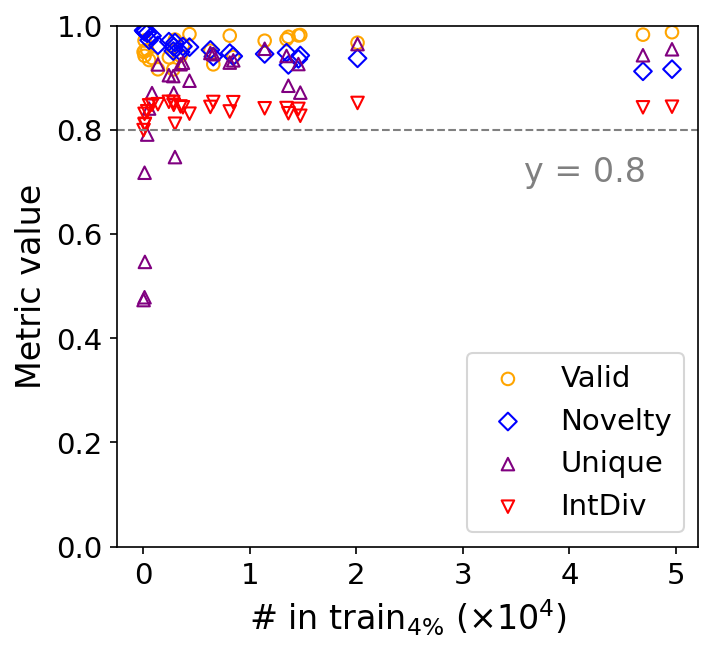

In [108]:
hac = metrics['n_train'] / 10000
valid = metrics['valid']
novel = metrics['novel']
unique = metrics['unique']
intdiv = metrics['intDiv']


plt.figure(figsize=(5, 4.6), dpi=150)
plt.scatter(hac, valid, label='Valid', marker='o', facecolors='none', edgecolors='orange')
plt.scatter(hac, novel, label='Novelty', marker='D', facecolors='none', edgecolors='blue')
plt.scatter(hac, unique, label='Unique', marker='^', facecolors='none', edgecolors='Purple')
plt.scatter(hac, intdiv, label='IntDiv', marker='v', facecolors='none', edgecolors='red')

plt.xlabel(r'# in $\mathdefault{train}_{4\%}\ (\times 10^4)$', fontsize=16)
plt.ylabel('Metric value', fontsize=16)
plt.legend(fontsize=14, loc='lower right')

# plt.axvline(x=0.1, color='gray', linestyle='dashed', linewidth=1)
plt.axhline(y=0.8, color='gray', linestyle='dashed', linewidth=1)

plt.text(0.7, 0.7, 'y = 0.8', transform=plt.gca().transAxes, fontsize=16, color='gray')
# plt.text(0.1, 0.05, 'x = 0.1', transform=plt.gca().transAxes, fontsize=16, color='gray')

plt.xticks(np.arange(0, 5+1, 1), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.ylim((0, 1))

plt.show()

### 誤差值 vs. # in train4%

In [10]:
err1 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/prop_sampling/cvaetf1-15/cvaetf1-15_error.csv', index_col=[0])
err2 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/prop_sampling/cvaetf2-15/cvaetf2-15_error.csv', index_col=[0])
err3 = pd.read_csv('/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/prop_sampling/cvaetf3-15/cvaetf3-15_error.csv', index_col=[0])
err = (err1 + err2 + err3) / 3

In [16]:
print(err['logP-MAE'].min())
print(err['tPSA-MAE'].min())
print(err['QED-MAE'].min())

0.17963700797926652
3.0761547024869866
0.018552994651218402


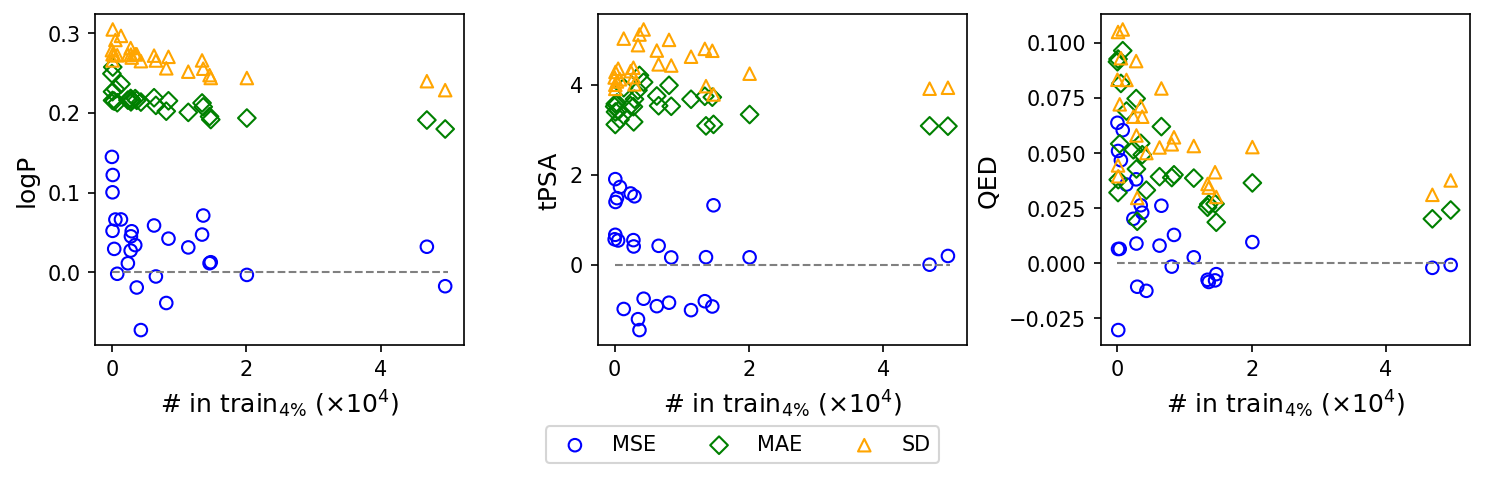

In [13]:
x = np.array(n_train) / 10000

# Plot 1: logP
y1_mse = err['logP-MSE']
y1_mae = err['logP-MAE']
y1_sd = err['logP-SD']

# Plot 2: tPSA
y2_mse = err['tPSA-MSE']
y2_mae = err['tPSA-MAE']
y2_sd = err['tPSA-SD']

# Plot 3: QED
y3_mse = err['QED-MSE']
y3_mae = err['QED-MAE']
y3_sd = err['QED-SD']

fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi=150)

# Plot 1: logP
axes[0].scatter(x, y1_mse, label='MSE', marker='o', facecolors='none', edgecolors='blue')
axes[0].scatter(x, y1_mae, label='MAE', marker='D', facecolors='none', edgecolors='green')
axes[0].scatter(x, y1_sd, label='SD', marker='^', facecolors='none', edgecolors='orange')
axes[0].set_xlabel(r'# in $\mathdefault{train}_{4\%}\ (\times 10^4)$', fontsize=12)
axes[0].set_ylabel('logP', fontsize=12)
axes[0].plot([0, 5], [0, 0], color='gray', linewidth=1, linestyle='dashed')

# Plot 2: tPSA
axes[1].scatter(x, y2_mse, label='MSE', marker='o', facecolors='none', edgecolors='blue')
axes[1].scatter(x, y2_mae, label='MAE', marker='D', facecolors='none', edgecolors='green')
axes[1].scatter(x, y2_sd, label='SD', marker='^', facecolors='none', edgecolors='orange')
axes[1].set_xlabel(r'# in $\mathdefault{train}_{4\%}\ (\times 10^4)$', fontsize=12)
axes[1].set_ylabel('tPSA', fontsize=12)
axes[1].plot([0, 5], [0, 0], color='gray', linewidth=1, linestyle='dashed')

# Plot 3: QED
axes[2].scatter(x, y3_mse, label='MSE', marker='o', facecolors='none', edgecolors='blue')
axes[2].scatter(x, y3_mae, label='MAE', marker='D', facecolors='none', edgecolors='green')
axes[2].scatter(x, y3_sd, label='SD', marker='^', facecolors='none', edgecolors='orange')
axes[2].set_xlabel(r'# in $\mathdefault{train}_{4\%}\ (\times 10^4)$', fontsize=12)
axes[2].set_ylabel('QED', fontsize=12)
axes[2].plot([0, 5], [0, 0], color='gray', linewidth=1, linestyle='dashed')

# Common legend at the bottom
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.07))

plt.tight_layout()
plt.show()

### 個案分析: logP, tPSA, QED = 1, 30, 0.60

In [32]:
train = pd.read_csv('/fileserver-gamma/chaoting/ML/dataset/moses/raw/train.csv', index_col=[0])
# train = train.dropna(subset=['scaffold'])

subtr = train[(1 - tol[0] <= train.logP) & (train.logP <= 1 + tol[0])]
subtr = subtr[(30 - tol[1] <= subtr.tPSA) & (subtr.tPSA <= 30 + tol[1])]
subtr = subtr[(0.6 - tol[2] <= subtr.QED) & (subtr.QED <= 0.6 + tol[2])]

In [33]:
file_folder = '/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/prop_sampling/'
comb_no = 0

prop1 = pd.read_csv(os.path.join(file_folder, f'cvaetf1-15/cvaetf1-15_prop_{comb_no}.csv'), index_col=[0])
prop2 = pd.read_csv(os.path.join(file_folder, f'cvaetf2-15/cvaetf2-15_prop_{comb_no}.csv'), index_col=[0])
prop3 = pd.read_csv(os.path.join(file_folder, f'cvaetf3-15/cvaetf3-15_prop_{comb_no}.csv'), index_col=[0])
prop = pd.concat([prop1, prop2, prop3], axis=0)

prop.head()

,SMILES,logP,tPSA,QED,SAS,NP,MW,HAC,HBA,HBD
0,C#CCN1CCN(CC(=O)N(CC(F)(F)F)C(C)C)CC1,1.0365,26.79,0.710161,2.616805,-2.212360,305.344,21,3,0
1,O=C(CN1CCN(CC(F)(F)C(F)F)CC1)N1CC=CC1,0.9028,26.79,0.557683,2.908871,-1.446183,309.307,21,3,0
2,C#CCN1CCN(C2CCN(C3CCCCC3)C2=O)CC1,1.1708,26.79,0.729878,3.015331,-0.889972,289.423,21,3,0
3,C#CCN1CCN(CC(=O)N2CCC(N(C(C)C)C(C)C)CC2)CC1,1.3470,30.03,0.677996,2.697337,-1.473579,348.535,25,4,0
4,O=C(C1CC1)N1CCN2CCN(C3CCN(CC(F)(F)F)CC3)CC21,1.2090,30.03,0.756915,3.222893,-1.387797,360.424,25,4,0


In [38]:
def property_filter(df):
    df = df[(1 - tol[0] <= df.logP) & (df.logP <= 1 + tol[0])]
    df = df[(30 - tol[1] <= df.tPSA) & (df.tPSA <= 30 + tol[1])]
    df = df[(0.6 - tol[2] <= df.QED) & (df.QED <= 0.6 + tol[2])]
    df = df.drop_duplicates(subset='SMILES')
    return df

filtered_set = property_filter(prop)

print('# unique set falling within tolerance:', len(filtered_set))

# unique set falling within tolerance: 1045


In [43]:
def get_specific_set(prop):
    specific_set = prop[(1 - tol[0] <= prop.logP) & (prop.logP <= 1 + tol[0]) &
                        (30 - tol[1] <= prop.tPSA) & (prop.tPSA <= 30) &
                        (0.60 - tol[2] <= prop.QED) & (prop.QED <= 0.60 + tol[2])]
    specific_set = specific_set.drop_duplicates(subset='SMILES')
    print('# nuique set falling within our specification:', len(specific_set))
    return specific_set

specific_set = get_specific_set(prop)

# nuique set falling within our specification: 278


In [46]:
a1 = get_specific_set(property_filter(prop1))
a2 = get_specific_set(property_filter(prop2))
a3 = get_specific_set(property_filter(prop3))

print((len(a1) + len(a2) + len(a3)) / 3)

# nuique set falling within our specification: 137
# nuique set falling within our specification: 72
# nuique set falling within our specification: 127
112.0


In [48]:
from Utils.mapper import mapper
from Utils.smiles import murcko_scaffold

specific_set['scaffold'] = mapper(murcko_scaffold, specific_set['SMILES'], n_jobs=16)
novel_scaffold_molecule_set = specific_set[~specific_set['scaffold'].isin(train['scaffold'])]
unique_novel_scaffold_set = novel_scaffold_molecule_set.drop_duplicates(subset=['scaffold'])

print('# novel and unique molecules:', len(novel_scaffold_molecule_set))
print('# novel and unique scaffolds:', len(unique_novel_scaffold_set))

# novel and unique molecules: 157
# novel and unique scaffolds: 116


In [50]:
df = unique_novel_scaffold_set.copy()
df['logP-MAE'] = (df['logP'] - 1).abs()
df['tPSA-MAE'] = (df['tPSA'] - 30).abs()
df['QED-MAE'] = (df['QED'] - 0.6).abs()

In [51]:
import itertools

def get_combinations(lst):
    combinations = []
    for r in range(1, len(lst) + 1):
        permutations = itertools.permutations(lst, r)
        combinations.extend(permutations)
    return combinations

prop_mae = get_combinations(['logP-MAE', 'tPSA-MAE', 'QED-MAE'])

In [52]:
cumm_df = None

for i, mae in enumerate(prop_mae):
    sorted_df = df.sort_values(by=list(mae))
    if i == 0:
        cumm_df = sorted_df[:3].copy()
    else:
        cumm_df = pd.concat([cumm_df, sorted_df[:3]], axis=0)

In [53]:
cumm_df = cumm_df.drop_duplicates('SMILES')

In [54]:
cumm_df = cumm_df.reset_index(drop=True)

In [96]:
n = 8
descriptions = []
for i in range(n):
    descriptions.append(f'logP={cumm_df.loc[i, "logP"]:.1f} '
                        f'tPSA={cumm_df.loc[i, "tPSA"]:.0f} '
                        f'QED={cumm_df.loc[i, "QED"]:.2f}')
smiles = cumm_df['SMILES'][[0,1,2,3,5,6,7,8]]
scaffold = mapper(murcko_scaffold, smiles, n_jobs=1)

plot_smiles_group(
    smiles=smiles,
    substructure=scaffold,
    save_path='./1.png',
    img_size=(500, 350),
    n_per_mol=4,
    descriptions=descriptions
)

In [101]:
cumm_df.to_csv("/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/prop_sampling/case-study/evaluation.csv")

### 特定範圍

In [1]:
from Utils.smiles import plot_smiles

file_folder = '/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/prop_sampling/case-study/'

for i in range(len(cumm_df)):
    plot_smiles(cumm_df['SMILES'].iloc[i], os.path.join(file_folder, f'smiles-{i}.png'), size=(500,260))
    plot_smiles(cumm_df['scaffold'].iloc[i], os.path.join(file_folder, f'scaffold-{i}.png'), size=(500,260))

/home/chaoting/software/miniconda3/envs/py385/lib/python3.8/site-packages/moses/metrics/utils.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _mcf.append(_pains, sort=True)['smarts'].values]


NameError: name 'cumm_df' is not defined

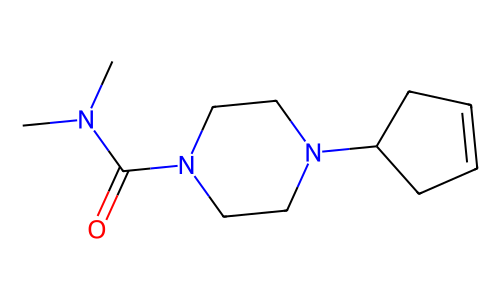

In [98]:
from rdkit import Chem

mol = Chem.MolFromSmiles('CN(C)C(=O)N1CCN(C2CC=CC2)CC1')
Chem.Draw.MolToImage(mol, size=(500,300))

### P-VAETF: Metrics and Errors

In [10]:
file_folder = '/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/prop_sampling'
file_name_list = ['cvaetf1-15', 'cvaetf2-15', 'cvaetf3-15']

In [26]:
trg_prop_list = get_trg_prop_list()
trg_prop = pd.DataFrame(trg_prop_list, columns=['logP', 'tPSA', 'QED'])
metric = pd.read_csv(os.path.join(file_folder, 'metric-15_15_15.csv'), index_col=[0])
n_train = get_n_train()

In [27]:
df1 = pd.read_csv(os.path.join(file_folder, file_name_list[0], f'{file_name_list[0]}_error.csv'), index_col=[0])
df2 = pd.read_csv(os.path.join(file_folder, file_name_list[1], f'{file_name_list[1]}_error.csv'), index_col=[0])
df3 = pd.read_csv(os.path.join(file_folder, file_name_list[2], f'{file_name_list[2]}_error.csv'), index_col=[0])
df = (df1 + df2 + df3) / 3
df[['logP', 'tPSA', 'QED']] = trg_prop
df[metric.columns] = metric
df['n_train'] = n_train

In [28]:
df.sort_values('unique_in_tolerance', ascending=False)[:1]

,logP-MSE,logP-MAE,logP-SD,tPSA-MSE,tPSA-MAE,tPSA-SD,QED-MSE,QED-MAE,QED-SD,valid_in_tolerance,unique_in_tolerance,logP,tPSA,QED,valid,unique,novel,intDiv,n_train
14,0.032082,0.190865,0.239575,0.001915,3.082839,3.907742,-0.002147,0.020102,0.031005,6991.333333,6741.0,2.0,60.0,0.85,0.982667,0.943148,0.912315,0.843211,46898


In [29]:
df.sort_values('unique_in_tolerance', ascending=True)[:1]

,logP-MSE,logP-MAE,logP-SD,tPSA-MSE,tPSA-MAE,tPSA-SD,QED-MSE,QED-MAE,QED-SD,valid_in_tolerance,unique_in_tolerance,logP,tPSA,QED,valid,unique,novel,intDiv,n_train
0,0.144686,0.249011,0.27847,0.565726,3.512734,4.156336,0.063702,0.091402,0.083241,1166.0,427.0,1.0,30.0,0.6,0.949567,0.473198,0.990727,0.799501,13


In [32]:
df

,logP-MSE,logP-MAE,logP-SD,tPSA-MSE,tPSA-MAE,tPSA-SD,QED-MSE,QED-MAE,QED-SD,valid_in_tolerance,unique_in_tolerance,logP,tPSA,QED,valid,unique,novel,intDiv,n_train
0,0.144686,0.249011,0.278470,0.565726,3.512734,4.156336,0.063702,0.091402,0.083241,1166.000000,427.000000,1.0,30.0,0.600,0.949567,0.473198,0.990727,0.799501,13
1,0.100302,0.226424,0.265570,0.664836,3.113228,3.903547,0.006414,0.032025,0.044351,4452.666667,2132.333333,1.0,30.0,0.725,0.971367,0.478570,0.989029,0.810289,102
2,0.121971,0.257259,0.304432,1.393466,3.391934,4.279533,-0.030395,0.037890,0.039429,3813.666667,1897.666667,1.0,30.0,0.850,0.952167,0.546473,0.991095,0.811587,136
3,0.066162,0.229601,0.291245,0.539355,3.416526,4.350589,0.046713,0.081571,0.093025,2422.666667,1999.333333,1.0,60.0,0.600,0.934000,0.840828,0.972114,0.846975,530
4,0.045114,0.213689,0.272950,0.406253,3.171443,4.162405,0.008889,0.042757,0.057959,3980.666667,3515.333333,1.0,60.0,0.725,0.951200,0.870725,0.959029,0.848004,2842
5,0.071194,0.207409,0.255234,0.168671,3.082543,3.963936,-0.008555,0.026725,0.034296,5359.666667,4940.000000,1.0,60.0,0.850,0.978467,0.884615,0.924597,0.831794,13608
6,0.066286,0.236111,0.296357,-0.980870,3.928197,5.019107,0.035670,0.069022,0.083146,2250.333333,2090.666667,1.0,90.0,0.600,0.916200,0.925526,0.962341,0.849225,1359
7,0.058707,0.218829,0.271622,-0.918257,3.745878,4.753679,0.007942,0.039235,0.052503,3930.000000,3779.666667,1.0,90.0,0.725,0.951933,0.947440,0.953469,0.843960,6285
8,0.047329,0.212262,0.265624,-0.808532,3.739759,4.791520,-0.007569,0.025381,0.035917,5836.000000,5603.333333,1.0,90.0,0.850,0.973800,0.941740,0.947986,0.841814,13433
9,0.051999,0.215483,0.273311,1.900784,3.569753,3.994650,0.050908,0.092637,0.104926,2605.666667,1702.666667,2.0,30.0,0.600,0.942033,0.717632,0.988462,0.830675,106
